# Age Trends Among Olympic Athletes
## by David Kobilnyk

## Investigation Overview

In this investigation, I wanted to look at the age trends of Olympic athletes over time. Are they getting younger or older, and are there subsets of athletes that show different patterns?

## Dataset Overview

The dataset consists of information regarding about 270,000 Olympic athlete/event combinations for Olympic games from 1896 to 2016, including Sex, Age, Country, Sport, Medal, and more. About 10,000 rows were removed due to missing Age information, and another approximately 5,000 were removed for being related to activities that were not as interesting for the analysis.

In [1]:
# Standard library
import itertools
import math
import random
import time


# Data science tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pandas defaults.
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)


# Suppress warnings from final output.
import warnings
warnings.simplefilter("ignore")


# Set up some chart defaults.
%matplotlib inline
plt.rcParams.update({'font.size': 14})
default_figwidth = 9
default_figheight = 9
default_figsize = (default_figwidth, default_figheight)
plt.figure(figsize=default_figsize);

<Figure size 648x648 with 0 Axes>

In [3]:
# Some helpful chart functions.
def centered_bins_of_size_from_series(size, series):
    min_x, max_x = series.agg(['min', 'max']).tolist()
    bins = np.arange(min_x, max_x + size + 1, size) - (size / 2)
    return bins

def histogram_of_series_with_bin_size(series, size, figsize=default_figsize):
    bins = centered_bins_of_size_from_series(size, series)
    series.hist(bins=bins, figsize=figsize)

def barplot_of_top_n_of_series(n, series, figsize=default_figsize):
    (
        series
        .value_counts()
        .head(n)
        .sort_values()
        .plot(kind='barh', figsize=figsize, color='C0')
    )

def labels_title(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def use_default_year_settings_for_x_axis(year_gap=12):
    plt.xlim(1895, 2017)
    year_ticks = range(1896, 2017, year_gap)
    plt.xticks(year_ticks, year_ticks)

def get_weights_for_norm_hist(df, groupby_col, percent=True):
    counts = df.groupby(groupby_col).count().iloc[:, 0].tolist()
    weights = np.array(list(itertools.chain(*[[1/n] * n for n in counts])))
    return weights * (100 if percent else 1)

# From https://stackoverflow.com/a/31302882/576101.
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)

def repeat_facetgrid_ticklabels():
    # From https://stackoverflow.com/a/52184614/576101.
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, labelleft=True)

In [4]:
df_explore = pd.read_csv('df_explore.csv', index_col=0)
df_athletes_explore = pd.read_csv('df_athletes_explore.csv', index_col=0)
df_season_athletes_explore = (
    pd.read_csv('df_season_athletes_explore.csv', index_col=0)
)
df_season_athletes_explore.rename_axis('SeasonAthleteID', inplace=True)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Mean Age of Olympic Athletes by Year, Season, and Gender

For males, the lowest mean age belongs to the very first Olympiad. There is a lot of volatility in the early years, even more so for females in particular, perhaps attributable to smaller quantities of age data for those earlier years. After that, the mean age of Olympic athletes mostly has a downward trend for ~80 years, and then has an upward trend until 2016. The mean age of females has more dramatic upward movements (closing much of the earlier age gap with men). The age gap closes more for Summer than for Winter. The large increase for both sexes from around 1980 on may be caused by the decline of amateurism and the increasing acceptance of professional athletes into the Olympics.

The two peaks around 1920 and 1948 mostly coincide with post-war games. Perhaps many athletes who had planned on competing in the canceled 1916, 1940, or 1944 games waited (and aged) until the next Olympics season, or many younger would-be athletes were unable to practice for the Olympics during the harsh war years.

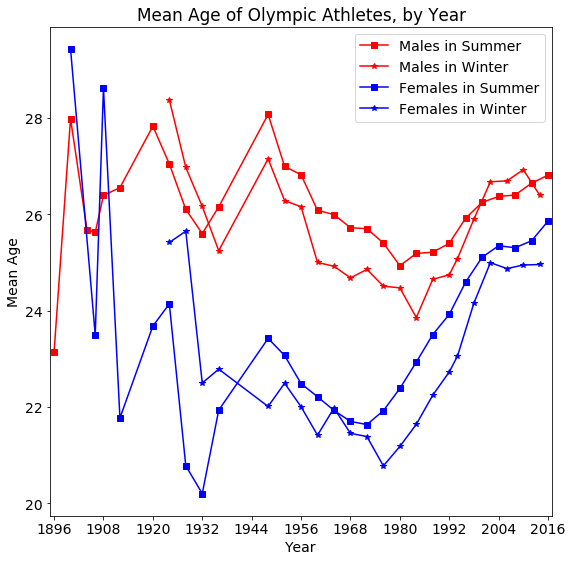

In [24]:
female = df_explore.IsFemale
male = ~df_explore.IsFemale
winter = df_explore.Season == 'Winter'
summer = df_explore.Season == 'Summer'

def remove_duplicate_athletes_by_year(df):
    return (
        df.groupby(['AthleteID', 'Year'])
        .Age.mean() # or min() or max(): the ages are same for a given athlete.
        .to_frame()
        .reset_index()
    )

def age_mean_by_year(df):
    return remove_duplicate_athletes_by_year(df).groupby('Year').Age.mean()

fw_age_means = age_mean_by_year(df_explore[female & winter])
fs_age_means = age_mean_by_year(df_explore[female & summer])
mw_age_means = age_mean_by_year(df_explore[male & winter])
ms_age_means = age_mean_by_year(df_explore[male & summer])

plt.figure(figsize=default_figsize)
plt.plot(ms_age_means, color='r', label='Males in Summer', marker='s');
plt.plot(mw_age_means, color='r', label='Males in Winter', marker='*');
plt.plot(fs_age_means, color='b', label='Females in Summer', marker='s');
plt.plot(fw_age_means, color='b', label='Females in Winter', marker='*');
plt.legend()

labels_title('Year', 'Mean Age', 'Mean Age of Olympic Athletes, by Year')
use_default_year_settings_for_x_axis()

## % of Athletes Over Time Who Competed in a Previous Olympiad, by Sex

There is a strong general trend toward a higher percentage of returning athletes over time, for both sexes. This trend contributes to the age increases we saw earlier. The temporary spike in 1994 could be related to the relaxation of amateurism rules in some activities. The upward trend seems to be hitting a plateau.

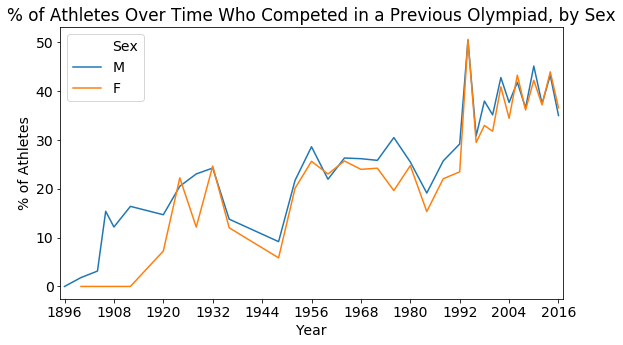

In [12]:
percent_repeat_athletes_by_year = (
    (df_explore[['AthleteID', 'HasPrevExp', 'Year', 'Sex']]
    .drop_duplicates()
    .groupby(['Year', 'Sex'])
    .HasPrevExp.mean() * 100)
    .to_frame()
    .reset_index()
)
plt.figure(figsize=(default_figwidth, 5))
sns.lineplot(
    data=percent_repeat_athletes_by_year,
    x='Year', y='HasPrevExp', hue='Sex'
)
use_default_year_settings_for_x_axis()
labels_title(
    'Year', '% of Athletes',
    '% of Athletes Over Time Who Competed in a Previous Olympiad, by Sex'
)

## Mean Age Over Time, by Gender and First/Last Olympiad

Some of the age increases in the past ~40 years appear to be driven by lengthening careers; however, a great deal of the age increase also occurs among first-time athletes. In recent times, the age gap between athletes in their first or last season has increased significantly while the age gap between males and females has decreased significantly, and now the bigger age gap appears to be between athletes in their first or last Olympics season rather than the age gap between males and females.

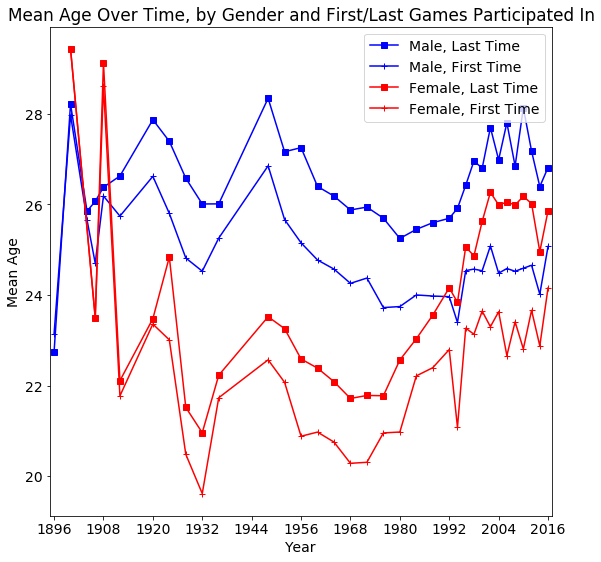

In [7]:
last_season = (df_explore.NSeasons == df_explore.NPreviousSeasons + 1)
new = (df_explore.NPreviousSeasons == 0)

df_female_first = df_explore[female & new]
df_female_last = df_explore[female & last_season]
df_male_first = df_explore[male & new]
df_male_last = df_explore[male & last_season]

female_first_by_year = age_mean_by_year(df_explore[female & new])
female_last_by_year = age_mean_by_year(df_explore[female & last_season])
male_first_by_year = age_mean_by_year(df_explore[male & new])
male_last_by_year = age_mean_by_year(df_explore[male & last_season])

plt.figure(figsize=default_figsize)
plt.plot(male_last_by_year, color='b', label='Male, Last Time', marker='s');
plt.plot(male_first_by_year, color='b', label='Male, First Time', marker='+');
plt.plot(female_last_by_year, color='r',
         label='Female, Last Time', marker='s');
plt.plot(female_first_by_year, color='r',
         label='Female, First Time', marker='+');
plt.legend()

labels_title('Year', 'Mean Age', 'Mean Age Over Time, by Gender and First/Last Games Participated In')
use_default_year_settings_for_x_axis()

## Mean Age Over Time, for First-Time Medalists and First-Time Non-Medalists

Since around 1960, medalists have generally been older than non-medalists.

Of the four groups here, female non-medalists have the largest age increase in modern times.

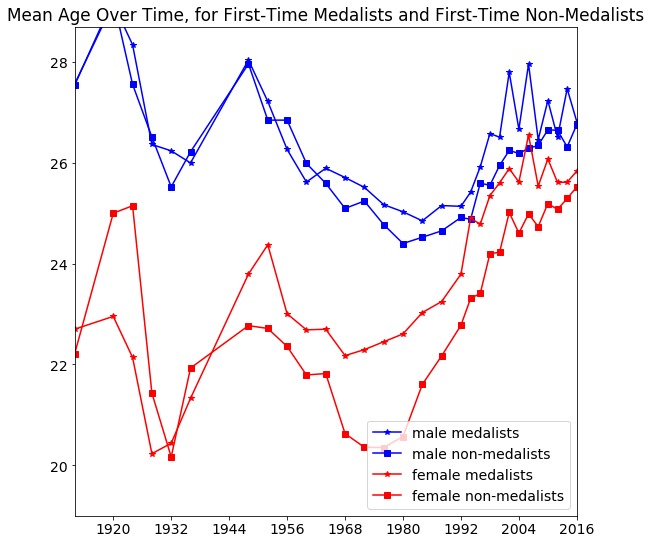

In [8]:
df_age_by_year_medal = (
    df_explore
    .groupby(['Year', 'Sex', 'WonMedal']).Age.mean().to_frame().reset_index()
)
plt.figure(figsize=default_figsize)
male = df_age_by_year_medal.Sex == 'M'
won_medal = df_age_by_year_medal.WonMedal

plt.plot(df_age_by_year_medal[male & won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='*', color='b', label='male medalists')

plt.plot(df_age_by_year_medal[male & ~won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='s', color='b', label='male non-medalists')

plt.plot(df_age_by_year_medal[~male & won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='*', color='r', label='female medalists')
plt.plot(df_age_by_year_medal[~male & ~won_medal].copy()[['Year', 'Age']].set_index('Year'), marker='s', color='r', label='female non-medalists')


plt.title(
    'Mean Age Over Time, for First-Time Medalists and First-Time Non-Medalists'
)
use_default_year_settings_for_x_axis()
plt.xlim(1912, 2016)
plt.ylim(19, 28.7);
plt.legend();

## Age over Time for Selected Sports, Separated by Sex

The mean age trends vary widely among the various sports, with Athletics having a fairly linear upward trend throughout the entire timespan, and Figure Skating having a very steep U shape. Gymnastics maintains a very wide age margin between the sexes, whereas Speed Skating has closed the age gap in recent times. Despite the wide range of differences here, all of the sports except for Sailing do have at least some slight increase in mean age in modern times for both sexes.

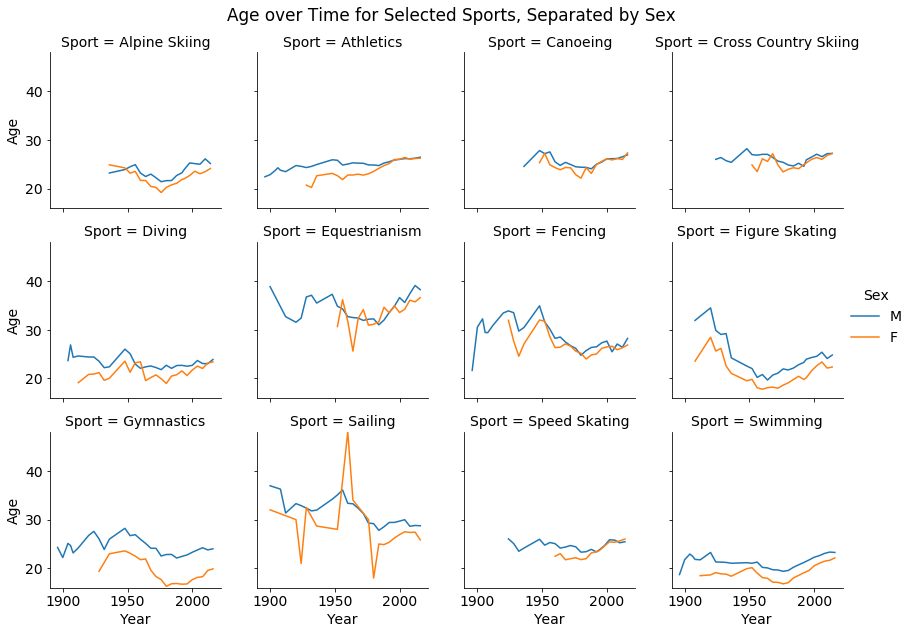

In [9]:
n_female_years_per_sport = (
    df_explore[df_explore.IsFemale]
    .groupby(['Sport', 'Year'])
    .AthleteID.count().to_frame().reset_index()
    .groupby('Sport').Year.count().sort_values()
)
most_freq_f_sports = sorted(n_female_years_per_sport.tail(12).index.tolist())

age_by_year_sport_sex = (
    df_explore
    [df_explore.Sport.isin(most_freq_f_sports)]
    .groupby(['Year', 'Sport', 'Sex'])
    .Age
    .mean()
    .to_frame()
    .reset_index()
)
g = sns.FacetGrid(
    data=age_by_year_sport_sex,
    hue='Sex',
    hue_order=['M', 'F'],
    col='Sport',
    col_wrap=4,
    col_order=most_freq_f_sports
)
plt.ylim(16, 48)
g.map(plt.plot, 'Year', 'Age');
g.fig.subplots_adjust(top=0.91)
g.fig.suptitle('Age over Time for Selected Sports, Separated by Sex');
g.add_legend();

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!